Etudiants :
<h5>Hamed Nazim MAMACHE</h5>
<h5>Gabin MAZUE</h5>
<h5>Thomas RIVES</h5>

# Entrainement de réseaux de neurones avec la différentiation auomatique

Cette partie consiste en l'implémentation de la classe Trainer.

In [1]:
import random
import os
import numpy as np

In [2]:
import torch
from torchvision.transforms.functional import to_tensor, normalize, affine
from PIL import Image
from typing import Tuple, List, NamedTuple
from tqdm import tqdm
import zipfile
from urllib import request
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import torchvision.transforms as TT

In [3]:
# Seed all random number generators
np.random.seed(197331)
torch.manual_seed(197331)
random.seed(197331)

In [4]:
class NetworkConfiguration(NamedTuple):
    n_channels: Tuple[int, ...] = (16, 32, 48)
    kernel_sizes: Tuple[int, ...] = (3, 3, 3)
    strides: Tuple[int, ...] = (1, 1, 1)
    dense_hiddens: Tuple[int, ...] = (256, 256)

In [5]:
class Trainer:
    def __init__(self,
                 network_type: str = "mlp",
                 net_config: NetworkConfiguration = NetworkConfiguration(),
                 lr: float = 0.001,
                 batch_size: int = 128,
                 activation_name: str = "relu"):
        self.train, self.test = self.load_dataset()
        self.network_type = network_type
        activation_function = self.create_activation_function(activation_name)
        input_dim = self.train[0].shape[1:]
        if network_type == "mlp":
            self.network = self.create_mlp(input_dim[0]*input_dim[1]*input_dim[2], 
                                           net_config,
                                           activation_function)
        elif network_type == "cnn":
            self.network = self.create_cnn(input_dim[0], 
                                           net_config, 
                                           activation_function)
        else:
            raise ValueError("Network type not supported")
        self.optimizer = torch.optim.Adam(self.network.parameters(), lr=lr)
        self.lr = lr
        self.batch_size = batch_size

        self.train_logs = {'train_loss': [], 'test_loss': [],
                           'train_mae': [], 'test_mae': []}

    @staticmethod
    def load_dataset() -> Tuple[Tuple[torch.Tensor, torch.Tensor], Tuple[torch.Tensor, torch.Tensor], Tuple[torch.Tensor, torch.Tensor]]:
        if not os.path.exists('./rotated_fashion_mnist'):
            url = 'https://drive.google.com/u/0/uc?id=1NQPmr01eIafQKeH9C9HR0lGuB5z6mhGb&export=download&confirm=t&uuid=645ff20a-d47b-49f0-ac8b-4a7347529c8e&at=AHV7M3d_Da0D7wowJlTzzZxDky5c:1669325231545'
            with request.urlopen(url) as f:
                with open('./rotated_fashion_mnist.zip', 'wb') as out:
                    out.write(f.read())
            with zipfile.ZipFile('./rotated_fashion_mnist.zip', 'r') as zip_ref:
                zip_ref.extractall()
            os.remove('./rotated_fashion_mnist.zip')
            
        datapath = './rotated_fashion_mnist'

        def get_paths_and_rots(split: str) -> List[Tuple[str, float]]:
            image_paths, rots = [], []
            files = os.listdir(os.path.join(datapath, split))
            for file in files:
                image_paths.append(os.path.join(datapath, split, file))
                rots.append(float(file.split('_')[1].split('.')[0]))
            return image_paths, rots
        
        def to_tensors(image_paths: List[str], rots: List[float]) -> Tuple[torch.Tensor, torch.Tensor]:
            images = [normalize(to_tensor(Image.open(path)), (0.5,), (0.5,)) 
                      for path in image_paths]
            images = torch.stack(images)
            labels = torch.tensor(rots).view(-1, 1)
            return images, labels

        X_train, y_train = to_tensors(*get_paths_and_rots('train'))
        X_test, y_test = to_tensors(*get_paths_and_rots('test'))
        
        # Normalize y for easier training
        mean, std = y_train.mean(), y_train.std()
        y_train = (y_train - mean) / std
        y_test = (y_test - mean) / std
        return (X_train, y_train), (X_test, y_test)

    @staticmethod
    def create_mlp(input_dim: int, net_config: NetworkConfiguration,
                   activation: torch.nn.Module) -> torch.nn.Module:
        """
        Create a multi-layer perceptron (MLP) network.

        :param net_config: a NetworkConfiguration named tuple. Only the field 'dense_hiddens' will be used.
        :param activation: The activation function to use.
        :return: A PyTorch model implementing the MLP.
        """
        layers = []
        layers.append(torch.nn.Flatten())
        for i in range(len(net_config.dense_hiddens)):
            layers.append(torch.nn.Linear(in_features = input_dim, out_features = net_config.dense_hiddens[i]))
            layers.append(activation)
            input_dim = net_config.dense_hiddens[i]
        layers.append(torch.nn.Linear(in_features = net_config.dense_hiddens[-1], out_features = 1))
        return torch.nn.Sequential(*layers)

    @staticmethod
    def create_cnn(in_channels: int, net_config: NetworkConfiguration,
                   activation: torch.nn.Module) -> torch.nn.Module:
        """
        Create a convolutional network.

        :param in_channels: The number of channels in the input image.
        :param net_config: a NetworkConfiguration specifying the architecture of the CNN.
        :param activation: The activation function to use.
        :return: A PyTorch model implementing the CNN.
        """
        layers = []
        for i in range(len(net_config.n_channels)):
            if i == len(net_config.n_channels) - 1:
                layers.append(torch.nn.Conv2d(in_channels = in_channels, out_channels = net_config.n_channels[i], kernel_size = net_config.kernel_sizes[i], stride=net_config.strides[i]))
                layers.append(torch.nn.AdaptiveMaxPool2d((4, 4)))
            else : 
                layers.append(torch.nn.Conv2d(in_channels = in_channels, out_channels = net_config.n_channels[i], kernel_size = net_config.kernel_sizes[i], stride=net_config.strides[i]))
                layers.append(activation)
                layers.append(torch.nn.MaxPool2d(kernel_size = 2))
                in_channels = net_config.n_channels[i]
        layers.append(torch.nn.Flatten())
        input_dim = 4 * 4 * net_config.n_channels[-1]
        for i in range(len(net_config.dense_hiddens)):
            layers.append(torch.nn.Linear(in_features = input_dim, out_features = net_config.dense_hiddens[i]))
            layers.append(activation)
            input_dim = net_config.dense_hiddens[i]
        layers.append(torch.nn.Linear(in_features = net_config.dense_hiddens[-1], out_features = 1))
        return torch.nn.Sequential(*layers)

    @staticmethod
    def create_activation_function(activation_str: str) -> torch.nn.Module:
        if activation_str == "relu":
            return torch.nn.ReLU()
        elif activation_str == "tanh":
            return torch.nn.Tanh()
        elif activation_str == "sigmoid":
            return torch.nn.Sigmoid()
        else:
            raise ValueError(f"Unknown activation function: {activation_str}")


    def compute_loss_and_mae(self, X: torch.Tensor, y: torch.Tensor) -> Tuple[torch.Tensor, torch.Tensor]:
        y_pred = self.network(X)
        loss = torch.mean((y_pred - y) ** 2)
        mae = torch.mean(torch.abs(y_pred - y))
        return loss, mae

    def training_step(self, X_batch: torch.Tensor, y_batch: torch.Tensor):
        self.network.train()
        self.optimizer.zero_grad()
        loss, _ = self.compute_loss_and_mae(X_batch, y_batch)
        loss.backward()
        self.optimizer.step()
        return loss

    def log_metrics(self, X_train: torch.Tensor, y_train: torch.Tensor,
                    X_test: torch.Tensor, y_test: torch.Tensor) -> None:
        self.network.eval()
        with torch.inference_mode():
            train_loss, train_mae = self.compute_loss_and_mae(X_train, y_train)
            test_loss, test_mae = self.compute_loss_and_mae(X_test, y_test)
        self.train_logs['train_mae'].append(train_mae.item())
        self.train_logs['test_mae'].append(test_mae.item())
        self.train_logs['train_loss'].append(train_loss.item())
        self.train_logs['test_loss'].append(test_loss.item())

    def train_loop(self, n_epochs: int):
        # Prepare train and validation data
        X_train, y_train = self.train
        X_test, y_test = self.test

        n_batches = int(np.ceil(X_train.shape[0] / self.batch_size))

        self.log_metrics(X_train[:2000], y_train[:2000], X_test, y_test)
        for epoch in tqdm(range(n_epochs)):
            for batch in range(n_batches):
                minibatchX = X_train[self.batch_size * batch:self.batch_size * (batch + 1), :]
                minibatchY = y_train[self.batch_size * batch:self.batch_size * (batch + 1), :]
                self.training_step(minibatchX, minibatchY)
            self.log_metrics(X_train[:2000], y_train[:2000], X_test, y_test)
        return self.train_logs

    def evaluate(self, X: torch.Tensor, y: torch.Tensor) -> Tuple[torch.Tensor, torch.Tensor]:
        self.network.eval()
        with torch.inference_mode():
            loss, mae = self.compute_loss_and_mae(X, y)
        return loss, mae

    def test_equivariance(self):
        from functools import partial
        test_im = (self.train[0][0] + 1) / 2
        conv = torch.nn.Conv2d(kernel_size=3, in_channels=1, out_channels=1, stride=1, padding=0)
        fullconv_model = lambda x: torch.relu(conv((torch.relu(conv((x))))))
        model = fullconv_model

        shift_amount = 5
        shift = partial(affine, angle=0, translate=(shift_amount, shift_amount), scale=1, shear=0)
        rotation = partial(affine, angle=90, translate=(0, 0), scale=1, shear=0)

        cnn_im = model(test_im)
        cnn_im_shifted_entry = model(shift(test_im))
        cnn_im_rotated_entry = model(rotation(test_im))

        transform = TT.ToPILImage()

        fig, axs = plt.subplots(2, 2, figsize=(10, 10))
        axs[0, 0].imshow(transform(test_im), cmap = 'gray_r')
        axs[0, 0].set_title('(1)')
        axs[0, 1].imshow(transform(cnn_im), cmap = 'gray_r')
        axs[0, 1].set_title('(2)')
        axs[1, 0].imshow(transform(torch.abs(shift(cnn_im) - cnn_im_shifted_entry)), cmap = 'gray_r')
        axs[1, 0].set_title('(3)')
        axs[1, 1].imshow(transform(torch.abs(rotation(cnn_im) - cnn_im_rotated_entry)), cmap = 'gray_r')
        axs[1, 1].set_title('(4)')
        fig.tight_layout()
        plt.show()

# Expérimentation sur le jeu de données FashionMNIST Tournée

Avant d'entraîner nos modèles, il serait intéressant d'observer à quoi ressemblent nos données. C'est ce qu'on fait tout d'abord ici :

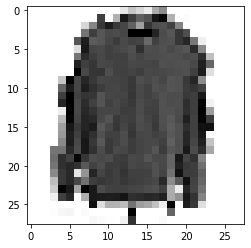

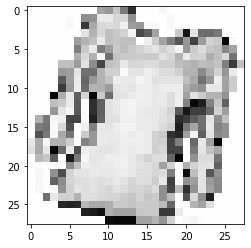

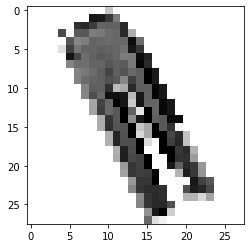

In [6]:
T = Trainer()
transform = TT.ToPILImage()
cpt = 0
for i in range(len(T.train[0])):
  img = transform(T.train[0][i])
  plt.imshow(img, cmap = 'gray_r')
  plt.show()
  cpt += 1
  if cpt == 3:
    break

## Entraînement d'un MLP

Dans cette partie, un MLP est entraîné avec 2 couches cachées, de taille 128 et 128 respectivement sur le jeu de données FashionMNIST Tournée, pour 50 époques, et une taille de batch 128. La fonction d’activation utilisée est ReLU.

On fait varier le Learning Rate dans l’ensemble {$0.01$, $1×10^{−4}$, $1×10^{−8}$}.

Voici l'entraînement des modèles :

In [7]:
T_lr1 = Trainer(net_config=NetworkConfiguration(dense_hiddens=[128, 128]), batch_size=128, activation_name="relu", lr = 0.01)
train_logs_lr1 = T_lr1.train_loop(50)
T_lr2 = Trainer(net_config=NetworkConfiguration(dense_hiddens=[128, 128]), batch_size=128, activation_name="relu", lr = 0.0001)
train_logs_lr2 = T_lr2.train_loop(50)
T_lr3 = Trainer(net_config=NetworkConfiguration(dense_hiddens=[128, 128]), batch_size=128, activation_name="relu", lr = 0.00000001)
train_logs_lr3 = T_lr3.train_loop(50)

100%|██████████| 50/50 [01:18<00:00,  1.58s/it]


Voici les résultats obtenus :

On peut ici observer l'évolution de la Loss pour le Train et le Test. Dans ces graphiques, les losses obtenus avec le Train sont en traits pleins, tandis que les losses obtenues avec le Test sont en traits hachurés.

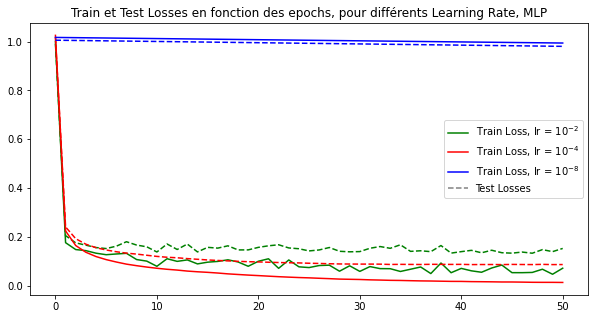

In [8]:
plt.figure(figsize=(10, 5))
plt.plot(train_logs_lr1['train_loss'], label='Train Loss, lr = '+ r'$10^{-2}$', color = 'green')
plt.plot(train_logs_lr1['test_loss'],linestyle='dashed', color = 'green')
plt.plot(train_logs_lr2['train_loss'], label='Train Loss, lr = '+ r'$10^{-4}$', color = 'red')
plt.plot(train_logs_lr2['test_loss'], linestyle='dashed', color = 'red')
plt.plot(train_logs_lr3['train_loss'], label='Train Loss, lr = '+ r'$10^{-8}$', color='blue')
plt.plot(train_logs_lr3['test_loss'], linestyle='dashed', color='blue')
handles, labels = plt.gca().get_legend_handles_labels()
line = Line2D([0], [0], color = 'grey',label='Test Losses', linestyle='dashed')
handles.extend([line])
plt.title('Train et Test Losses en fonction des epochs, pour différents Learning Rate, MLP')
plt.legend(handles = handles)
plt.show()

On peut ici observer l'évolution de la MAE pour le Train et le Test. Dans ces graphiques, les MAE obtenus avec le Train sont en traits pleins, tandis que les MAE obtenues avec le Test sont en traits hachurés.

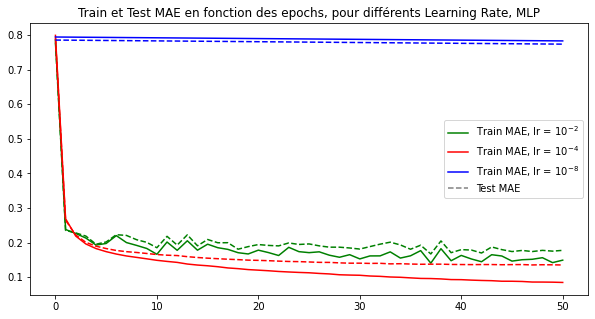

In [9]:
plt.figure(figsize=(10, 5))
plt.plot(train_logs_lr1['train_mae'], label='Train MAE, lr = '+ r'$10^{-2}$', color = 'green')
plt.plot(train_logs_lr1['test_mae'],linestyle='dashed', color = 'green')
plt.plot(train_logs_lr2['train_mae'], label='Train MAE, lr = '+ r'$10^{-4}$', color = 'red')
plt.plot(train_logs_lr2['test_mae'], linestyle='dashed', color = 'red')
plt.plot(train_logs_lr3['train_mae'], label='Train MAE, lr = '+ r'$10^{-8}$', color='blue')
plt.plot(train_logs_lr3['test_mae'], linestyle='dashed', color='blue')
handles, labels = plt.gca().get_legend_handles_labels()
line = Line2D([0], [0], color = 'grey',label='Test MAE', linestyle='dashed')
handles.extend([line])
plt.title('Train et Test MAE en fonction des epochs, pour différents Learning Rate, MLP')
plt.legend(handles = handles)
plt.show()

Observations :

On observe de très mauvais résultats lorsque le Learning Rate est trop petit.
Lorsque celui-ci est grand (égal à $10^{-2}$), les résultats restent moins bons que lorsqu'il est égale à $10^{-4}$. 

Il faut ainsi, pour optimiser les performances, trouver un genre d'équilibre pour calibrer un bon Learning Rate.

Il est intéressant de noter que, dans le cas du Learning Rate = $10^{-8}$, la Loss et la MAE du Test sont meilleures que celles du Train.

## Entraînement d'un CNN

Dans cette partie, un CNN sur le jeu de données FashionMNIST Tournée est entraîné pour 50 époques avec une taille de batch 128. La fonction d’activation utilisée est ReLU. Trois couches convolutionnelles cachées avec un nombre de filtres de (16, 32, 45), des noyaux de taille 3, et un “stride” de 1 ont été utilisés. Enfin, nous avons implémenté une dernière couche cachée entièrement connectée avec 128 neurones.

Nous avons représenté les résultats obtenus avec un Learning Rate laissé par défaut (à $10^{-3}$).

Puis, nous avons fait varier celui-ci, comme précedemment, dans l’ensemble {$0.01$, $1×10^{−4}$, $1×10^{−8}$}.

In [10]:
T_cnn = Trainer(net_config=NetworkConfiguration(n_channels=[16, 32, 45],kernel_sizes = [3, 3, 3], strides = [1, 1, 1], dense_hiddens=[128]), batch_size=128, activation_name="relu")
train_logs_cnn = T_cnn.train_loop(50)

100%|██████████| 50/50 [01:03<00:00,  1.26s/it]


Voici les résultats obtenus avec un Learning Rate laissé par défaut (à $10^{-3}$) :

On peut ici observer l'évolution de la Loss pour le Train et le Test. Dans ces graphiques, les losses obtenus avec le Train sont en traits pleins, tandis que les losses obtenues avec le Test sont en traits hachurés.

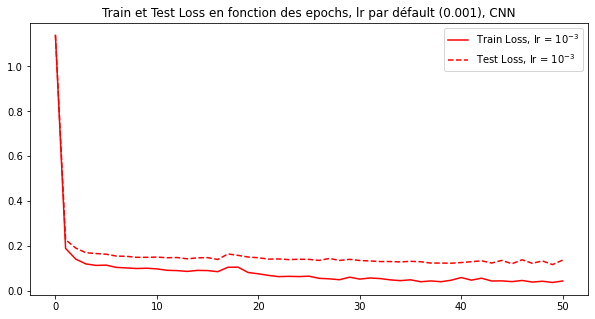

In [11]:
plt.figure(figsize=(10, 5))
plt.plot(train_logs_cnn['train_loss'], label='Train Loss, lr = '+ r'$10^{-3}$', color = 'red')
plt.plot(train_logs_cnn['test_loss'],linestyle='dashed', color = 'red', label='Test Loss, lr = '+ r'$10^{-3}$')
plt.title('Train et Test Loss en fonction des epochs, lr par défault (0.001), CNN')
plt.legend()
plt.show()

On peut ici observer l'évolution de la MAE pour le Train et le Test. Dans ces graphiques, les MAE obtenus avec le Train sont en traits pleins, tandis que les MAE obtenues avec le Test sont en traits hachurés.

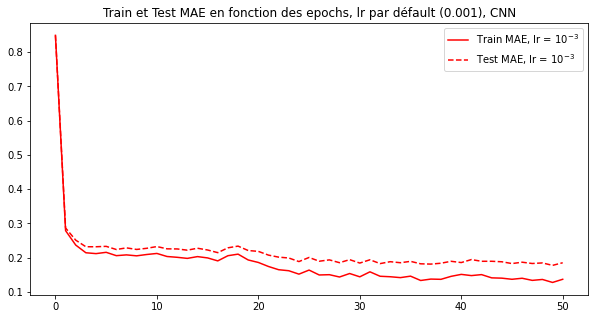

In [12]:
plt.figure(figsize=(10, 5))
plt.plot(train_logs_cnn['train_mae'], label='Train MAE, lr = '+ r'$10^{-3}$', color = 'red')
plt.plot(train_logs_cnn['test_mae'],linestyle='dashed', color = 'red', label='Test MAE, lr = '+ r'$10^{-3}$')
plt.title('Train et Test MAE en fonction des epochs, lr par défault (0.001), CNN')
plt.legend()
plt.show()

Enfin, voici les résultats obtenus avec un Learning Rate dans l’ensemble {$0.01$, $1×10^{−4}$, $1×10^{−8}$} :

In [13]:
T_cnn_lr1 = Trainer(net_config=NetworkConfiguration(n_channels=[16, 32, 45],kernel_sizes = [3, 3, 3], strides = [1, 1, 1], dense_hiddens=[128]), batch_size=128, activation_name="relu", lr = 0.01)
train_logs_cnn_lr1 = T_cnn_lr1.train_loop(50)
T_cnn_lr2 = Trainer(net_config=NetworkConfiguration(n_channels=[16, 32, 45],kernel_sizes = [3, 3, 3], strides = [1, 1, 1], dense_hiddens=[128]), batch_size=128, activation_name="relu", lr = 0.0001)
train_logs_cnn_lr2 = T_cnn_lr2.train_loop(50)
T_cnn_lr3 = Trainer(net_config=NetworkConfiguration(n_channels=[16, 32, 45],kernel_sizes = [3, 3, 3], strides = [1, 1, 1], dense_hiddens=[128]), batch_size=128, activation_name="relu", lr = 0.00000001)
train_logs_cnn_lr3 = T_cnn_lr3.train_loop(50)

100%|██████████| 50/50 [00:55<00:00,  1.11s/it]


On peut ici observer l'évolution de la Loss pour le Train et le Test. Dans ces graphiques, les Losses obtenus avec le Train sont en traits pleins, tandis que les Losses obtenues avec le Test sont en traits hachurés.

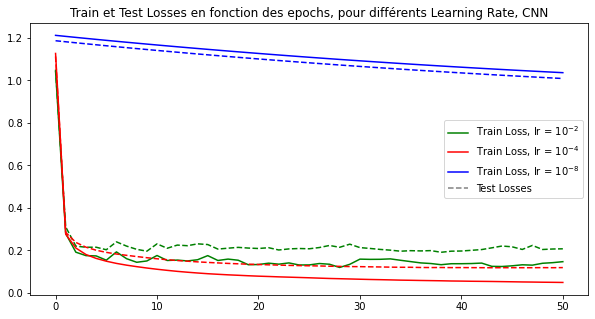

In [14]:
plt.figure(figsize=(10, 5))
plt.plot(train_logs_cnn_lr1['train_loss'], label='Train Loss, lr = '+ r'$10^{-2}$', color = 'green')
plt.plot(train_logs_cnn_lr1['test_loss'],linestyle='dashed', color = 'green')
plt.plot(train_logs_cnn_lr2['train_loss'], label='Train Loss, lr = '+ r'$10^{-4}$', color = 'red')
plt.plot(train_logs_cnn_lr2['test_loss'], linestyle='dashed', color = 'red')
plt.plot(train_logs_cnn_lr3['train_loss'], label='Train Loss, lr = '+ r'$10^{-8}$', color='blue')
plt.plot(train_logs_cnn_lr3['test_loss'], linestyle='dashed', color='blue')
handles, labels = plt.gca().get_legend_handles_labels()
line = Line2D([0], [0], color = 'grey',label='Test Losses', linestyle='dashed')
handles.extend([line])
plt.title('Train et Test Losses en fonction des epochs, pour différents Learning Rate, CNN')
plt.legend(handles = handles)
plt.show()

On peut ici observer l'évolution de la MAE pour le Train et le Test. Dans ces graphiques, les MAE obtenus avec le Train sont en traits pleins, tandis que les MAE obtenues avec le Test sont en traits hachurés.

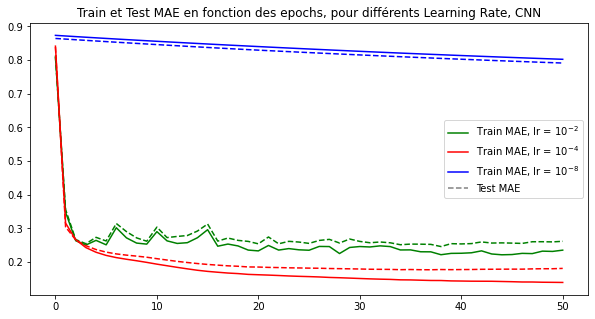

In [15]:
plt.figure(figsize=(10, 5))
plt.plot(train_logs_cnn_lr1['train_mae'], label='Train MAE, lr = '+ r'$10^{-2}$', color = 'green')
plt.plot(train_logs_cnn_lr1['test_mae'],linestyle='dashed', color = 'green')
plt.plot(train_logs_cnn_lr2['train_mae'], label='Train MAE, lr = '+ r'$10^{-4}$', color = 'red')
plt.plot(train_logs_cnn_lr2['test_mae'], linestyle='dashed', color = 'red')
plt.plot(train_logs_cnn_lr3['train_mae'], label='Train MAE, lr = '+ r'$10^{-8}$', color='blue')
plt.plot(train_logs_cnn_lr3['test_mae'], linestyle='dashed', color='blue')
handles, labels = plt.gca().get_legend_handles_labels()
line = Line2D([0], [0], color = 'grey',label='Test MAE', linestyle='dashed')
handles.extend([line])
plt.title('Train et Test MAE en fonction des epochs, pour différents Learning Rate, CNN')
plt.legend(handles = handles)
plt.show()

Observations :

Comme c'était le cas pour le MLP, on observe de très mauvais résultats lorsque le Learning Rate est trop petit.
Lorsque celui-ci est grand (égal à $10^{-2}$), les résultats restent moins bons que lorsqu'il est égale à $10^{-4}$. 

Il faut ainsi, pour optimiser les performances, trouver un genre d'équilibre pour calibrer un bon Learning Rate.

Il est intéressant de noter que, encore une fois, dans le cas du Learning Rate = $10^{-8}$, la Loss et la MAE du Test sont meilleures que celles du Train.

# Représentations Équivariantes

Dans cette partie, nous explorons certaines propriétés des CNN, l'équivariance, entre autres.

On peut observer dans la cellule suivante ces 4 figures :

(1) Une figure montrant l’image originale, qui est la première image self.train[0][0] de l’ensemble d’apprentissage ;

(2) Une figure montrant les features de sortie du petit CNN lorsqu’on lui donne cette première image en entrée ;

(3) Une figure montrant l’image de la différence absolue pixel par pixel entre les features de sortie décalées étant donné l’entrée non décalée, et la sortie non décalée du CNN étant donné l’entrée décalée ;

(4) Une figure similaire, mais cette fois avec rotation. 

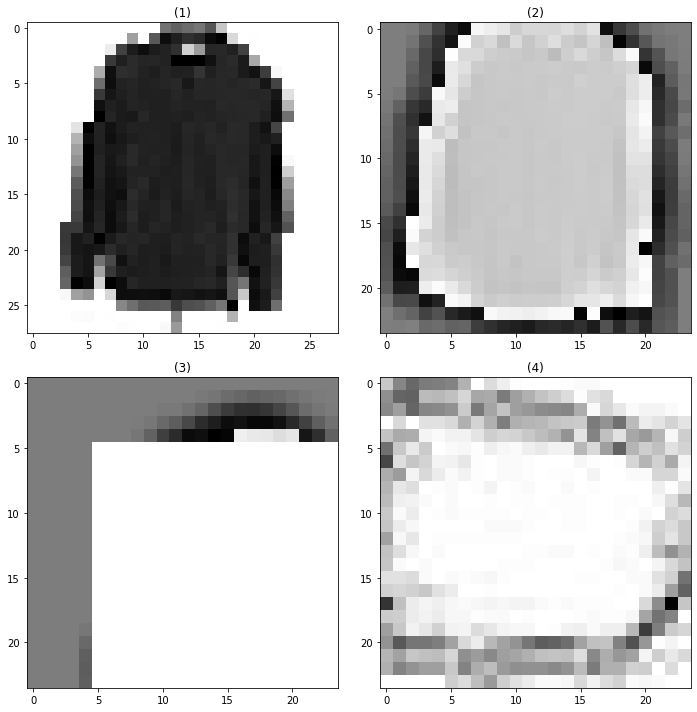

In [17]:
T = Trainer()
T.test_equivariance()

Observations :

1. On observe que les couches convolutives sont équivariantes pour les transformations de décalage (ou shift), comme le montre la figure (3) ci-dessus : on observe une grande surface où la différence absolue pixel par pixel est nulle lorsqu'on considère la transformation de décalage. En effet, les images décalées ont une différence égale à zéro pour la plupart des pixels, sauf sur le bord supérieur et gauche. La raison est que le décalage de l'image d'origine a créé des pixels noirs (des pixels ayant une valeur de zéro) à ces endroits là.

    Cependant, ce n'est pas le cas pour les transformations de rotation, comme le montre la figure (4) :  on observe seulement de très petites surfaces où la différence absolue pixel par pixel est nulle. Ces surfaces sont logiquement situés au niveau du centre de l'image. Cependant, ce n'est pas suffisant pour dire que les couches convolutives sont équivariantes pour les transformations de rotation.

    Cela peut s'expliquer par le fait que les couches convolutionnelles cherchent à détecter des motifs ou des caractéristiques spécifiques de l'image. En effet, les couches convolutionnelles appliquent des filtres à de petites parties d'une image donnée en entrée et sont sensibles aux patternes de celle-ci. De ce fait, lorsqu'une rotation est appliquée, le modèle ne reconnait pas les mêmes patternes et les mêmes motifs, ce qui explique nos observations ci-dessus, dans le cas de la rotation. Cependant, lorsqu'on applique un décalage, les motifs et les caractéristiques spécifiques de l'image restent intacts : ils sont seulement décalés, entrainant peu ou pas de différence dans les features de sortie.



2. L'équivariance à certaines transformations serait plus utile que l'équivariance à d'autres transformations pour l'apprentissage. En effet, lorsqu'on considère certaines transformations avec certaines propriétés, celles-ci peuvent faciliter l'apprentissage, en fonction de la façon dont elles interagissent avec l'algorithme d'apprentissage et la distribution des données. Considérons une transformation qui possède la particularité de préserver les propriétés qu'on juge importantes de nos données, des représentations abstraites très utiles par exemple. L'équivariance de notre modèle à cette transformation est très bénéfique et intéressante à exploiter pour l'apprentissage. De plus, si, dans notre tâche, on utilise une transformation équivariante, ça pourrait permettre un apprentissage plus facile avec moins de données. Si notre tâche consiste par exemple à prédire la position d'un objet dans l'espace, la transformation de shift serait très intéressante à exploiter.

    De plus, comme on a pu le voir dans le cas du CNN, l'équivariance est utile car l'algorithme peut apprendre à détecter des composants d'image communs, (tels que les bords, coins, et courbes dans des orientations bien spécifiques), pouvant apparaître à plusieurs endroits dans une image.
    
    Cependant, si l'exploitation d'une transformation n'est pas bénéfique à notre tâche, il est moins utile qu'elle soit équivariante. L'utilité de celle-ci dépend ainsi de sa relation avec l'algorithme, les données, mais aussi la tâche d'apprentissage.